# Predicting Home Sale Value 
### Author: Rohith Ravindranath 
### Email: rohithravin@ibm.com

In this notebook, we will be showing you how to create a machine learning model to predict home sales. At the same time, we will be use IBM's Db2 on Cloud database to store and recieve data for this exercise. In this notebook, we will be going through the entire data science process of creating a model which includes: Importing Data, Preprocessing Data, Data Exploration, Data Visualization and Data Modeling. We will try to fitting our data with differeent models and see which one gives us the best resuts. Hope you guys have fun!

# Import Libraries 

Before we start to do anything, we need to first import the necessary libraries for this notebook.

1. pandas - Allows easy manipulation of data structures.
2. numpy — Allows scientific computing.
3. sklearn — A machine learning library for python. (We will be importing this library in the Data Modeling step in this notebook)
4. matplotlib - Used to visualize our data.
5. seaborn - A Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
6. ibmdbpy - A Python interface for data manipulation and access to in-database algorithms in IBM Db2 (We will be importing this libaray in the Importing Data step in this notebook)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

# 1. IMPORTING DATA

The first step as data scienctist is to import our data from our data source. In real a world application, your data is going to be too big to be stored locally on your computer. Due to that, your data will most likely be stored on the cloud or in some other method. For the purposes of this notebook, our data is store on IBM Db2 on Cloud. In order to retrieve data from there, we are going to import IBM's python model `ibmdbpy` that allows Python users to import data from IBM's databases. Our data is stored in schema `SKP44849` and the table name is `HOME_SALES`.

In [2]:
from ibmdbpy import IdaDataBase, IdaDataFrame

# @hidden_cell
# This connection object is used to access your data and contains your credentials.
# You might want to remove those credentials before you share your notebook.
idadb_2cffb71b4b2348ab8a466c773c64691a = IdaDataBase(dsn='DASHDB;Database=BLUDB;Hostname=dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net;Port=50000;PROTOCOL=TCPIP;UID=skp44849;PWD=19btf^dph1ng0cnb')

data_df_1 = IdaDataFrame(idadb_2cffb71b4b2348ab8a466c773c64691a, 'SKP44849.HOME_SALES').as_dataframe()
data_df_1.head()

# You can close the database connection with the following code. Please keep the comment line with the @hidden_cell tag,
# because the close function displays parts of the credentials.

,ID,LOTAREA,BLDGTYPE,HOUSESTYLE,OVERALLCOND,YEARBUILT,ROOFSTYLE,EXTERCOND,FOUNDATION,BSMTCOND,...,GARAGETYPE,GARAGEFINISH,GARAGECARS,GARAGECOND,POOLAREA,POOLQC,FENCE,MOSOLD,YRSOLD,SALEPRICE
0,1,8450,1Fam,2Story,5,2003,Gable,TA,PConc,TA,...,Attchd,RFn,2,TA,0,NA,NA,2,2008,208500
1,2,9600,1Fam,1Story,8,1976,Gable,TA,CBlock,TA,...,Attchd,RFn,2,TA,0,NA,NA,5,2007,181500
2,3,11250,1Fam,2Story,5,2001,Gable,TA,PConc,TA,...,Attchd,RFn,2,TA,0,NA,NA,9,2008,223500
3,4,9550,1Fam,2Story,5,1915,Gable,TA,BrkTil,Gd,...,Detchd,Unf,3,TA,0,NA,NA,2,2006,140000
4,5,14260,1Fam,2Story,5,2000,Gable,TA,PConc,TA,...,Attchd,RFn,3,TA,0,NA,NA,12,2008,250000


By the end of this step, we should have your data imported from your data source and store in memory, so we can use it to create our model. In the next step, we are going to clean our data and make it ready for exploration and modeling.

# 2. Preprocess Data

When it comes to preprocessing our data, we want to clean our data and prepare it for future use. When trying to analyze and model our data we need to make sure that it is converted into numerical data. If you notice in our dataset, we have a lot of non-numerical categorical attributes that we need to convert to numerical categorical data. For this reason, I've created a method that will convert those specific attributes. 

In [3]:
#This method will convert the any non-numerical attributes into numerical.
# @param df - pandas dataframe
# @return df - cleaned pandas dataframe 
def handle_non_numerical_data(df):
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]
        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x = x + 1
            df[column] = list(map(convert_to_int,df[column]))
    return df

In [4]:
#Convert all non numerical attributes to numerical 
df = handle_non_numerical_data(data_df_1)

#We don't need to ID attribute in our dataframe since that doesn't have any impact when modeling our data
df = df.drop('ID', axis = 1)

#Split the data into x (features) and y (prices) for modeling purposes
prices = df['SALEPRICE']
features = df.drop('SALEPRICE', axis = 1)

print("Boston housing dataset has {} data points with {} variables each.".format(*df.shape))

Boston housing dataset has 1460 data points with 31 variables each.


# 3. Data Exploration

In this step, we are going to try and explore our data inorder to gain insight. We hope to be able to make some assumptions of our data before we start modeling. 

In [5]:
df.describe()

,LOTAREA,BLDGTYPE,HOUSESTYLE,OVERALLCOND,YEARBUILT,ROOFSTYLE,EXTERCOND,FOUNDATION,BSMTCOND,HEATING,...,GARAGETYPE,GARAGEFINISH,GARAGECARS,GARAGECOND,POOLAREA,POOLQC,FENCE,MOSOLD,YRSOLD,SALEPRICE
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,10516.828082,2.783562,2.084247,5.575342,1971.267808,3.770548,2.663014,3.121233,2.869178,2.035616,...,1.348630,1.780822,1.767123,2.943151,2.758904,0.010274,1.032877,6.321918,2007.815753,180921.195890
std,9981.264932,0.678468,2.218780,1.112799,30.202904,0.524998,0.930852,1.778237,0.667473,0.362903,...,1.825782,1.256610,0.747315,0.395556,40.177307,0.158916,0.610858,2.703626,1.328095,79442.502883
min,1300.000000,0.000000,0.000000,1.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,7553.500000,3.000000,0.000000,5.000000,1954.000000,4.000000,3.000000,2.000000,3.000000,2.000000,...,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1.000000,5.000000,2007.000000,129975.000000
50%,9478.500000,3.000000,1.000000,5.000000,1973.000000,4.000000,3.000000,2.000000,3.000000,2.000000,...,0.000000,2.000000,2.000000,3.000000,0.000000,0.000000,1.000000,6.000000,2008.000000,163000.000000
75%,11601.500000,3.000000,4.000000,6.000000,2000.000000,4.000000,3.000000,5.000000,3.000000,2.000000,...,4.000000,3.000000,2.000000,3.000000,0.000000,0.000000,1.000000,8.000000,2009.000000,214000.000000
max,215245.000000,4.000000,7.000000,9.000000,2010.000000,5.000000,4.000000,5.000000,4.000000,5.000000,...,6.000000,3.000000,4.000000,5.000000,738.000000,3.000000,4.000000,12.000000,2010.000000,755000.000000


The count, mean, min and max rows are self-explanatory. The std shows the standard deviation, and the 25%, 50% and 75% rows show the corresponding percentiles.

In [6]:
# Minimum price of the data
minimum_price = np.amin(prices)

# Maximum price of the data
maximum_price = np.amax(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for housing dataset:\n")
print("Minimum price: ${}".format(minimum_price)) 
print("Maximum price: ${}".format(maximum_price))
print("Mean price: ${}".format(mean_price))
print("Median price ${}".format(median_price))
print("Standard deviation of prices: ${}".format(std_price))

Statistics for housing dataset:

Minimum price: $34900
Maximum price: $755000
Mean price: $180921.19589041095
Median price $163000.0
Standard deviation of prices: $79415.29188606751


# 4. Data Visualization

As a data scientist it is important to make assumptions and hypothesiize about our data as we continue to explore our data. Some assumptions that we can make about the data are: 

1. Homes with more rooms will naturally worth more. Usually homes with more rooms are bigger and can fit more people, so it is reasonable that they cost more money.
2. Homes that have recently been built will cost more. Since they are newer and probably have a better design compared to older houses. 
3. Having a garage will also increase the price of the house and will increase more as the number of cars the garage can hold increases. 
4. House Style is usually a personal opinion for the buyer, so it shouldn't have that much impact on the cost of the home sale.

These are just a few of the assumptions we can make so far from our data. As we move into the visualizing our data, we hope to see patterns that are hard to notice just by looking at the numbers. 

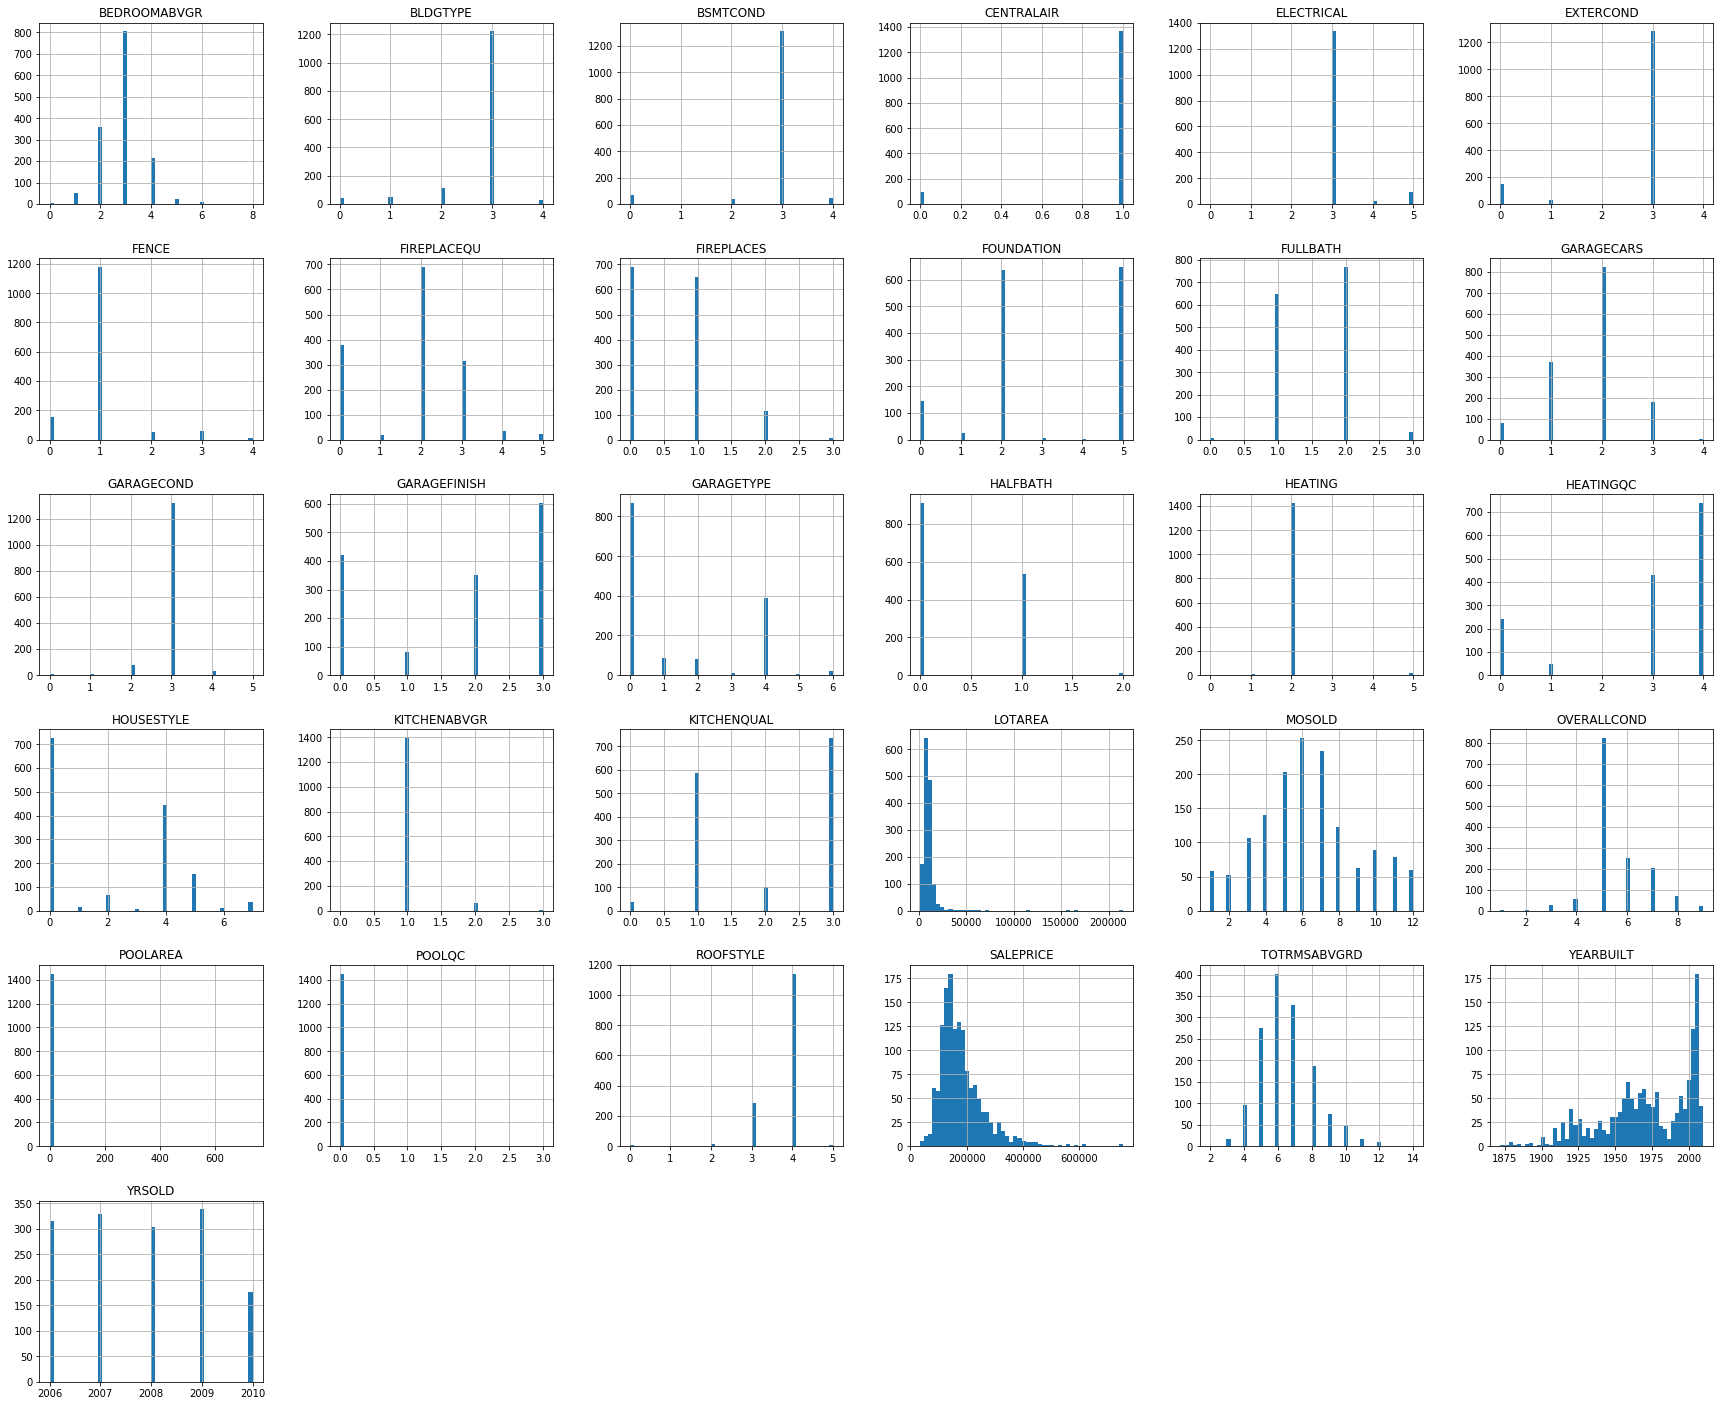

In [7]:
df.hist(bins=50, figsize=(30,25))
plt.show()

Some of the figures are skewed a little, but most of them have a normal distribution. This is normal to have.

The variable we are going to predict is the `SALEPRICE`. Let’s look at how much each independent variable correlates with this dependent variable.

In [8]:
corr_matrix = df.corr()
corr_matrix["SALEPRICE"].sort_values(ascending=False)

SALEPRICE       1.000000
GARAGECARS      0.640409
FULLBATH        0.560664
TOTRMSABVGRD    0.533723
YEARBUILT       0.522897
FOUNDATION      0.494438
FIREPLACES      0.466929
HEATINGQC       0.285565
HALFBATH        0.284108
LOTAREA         0.263843
CENTRALAIR      0.251328
BEDROOMABVGR    0.168213
BLDGTYPE        0.114298
GARAGECOND      0.104249
POOLAREA        0.092404
EXTERCOND       0.091001
POOLQC          0.051364
MOSOLD          0.046432
HOUSESTYLE      0.028821
FENCE           0.015356
HEATING        -0.014986
YRSOLD         -0.028923
BSMTCOND       -0.074708
OVERALLCOND    -0.077856
FIREPLACEQU    -0.109694
KITCHENABVGR   -0.135907
ROOFSTYLE      -0.194247
ELECTRICAL     -0.201338
GARAGEFINISH   -0.240409
KITCHENQUAL    -0.364920
GARAGETYPE     -0.395485
Name: SALEPRICE, dtype: float64

The `SALEPRICE` seems to be increasing when the `GARAGECARS` and the `FULLBATH` increase. We can also see a negative correlation between `SALEPRICE`  and `FOUNDATION` and a couple others. And finally, coefficients close to zero indicate that there is no linear correlation. However, we barely see any cofficients close to zeros, this tells us that all the attributes are important to `SALEPRICE`, which is the attribute we are predicting.

Let's also visualize some of these correlations through a scatter plot.

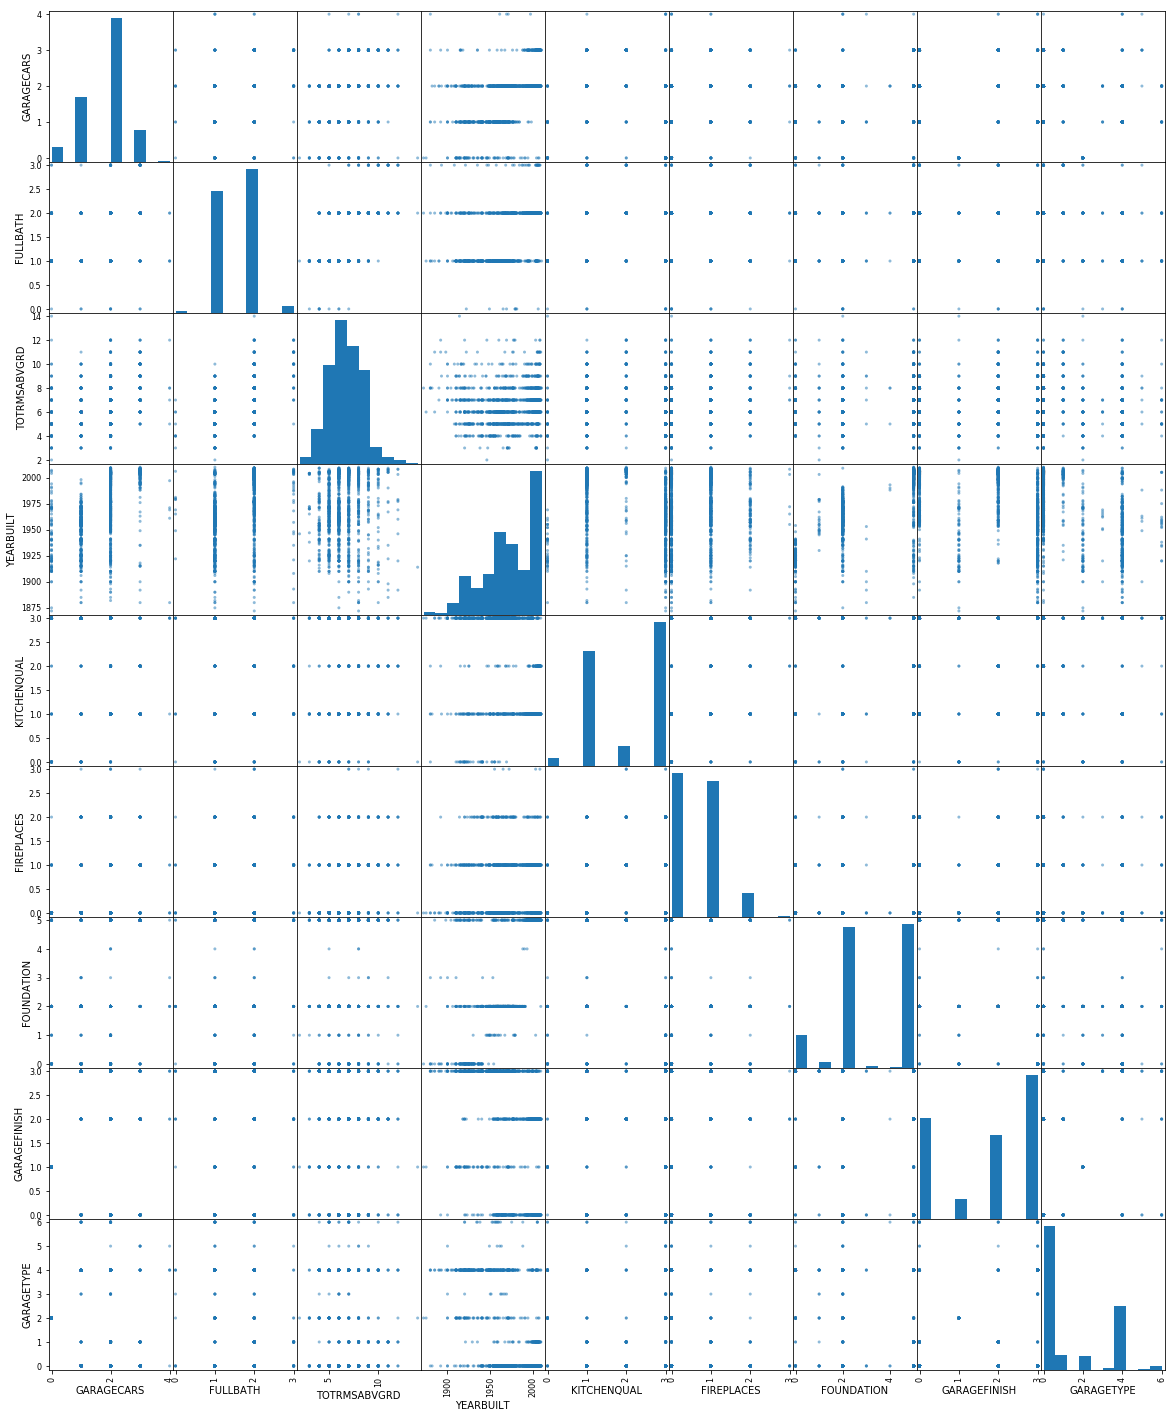

In [9]:
from pandas.plotting import scatter_matrix
attributes = ["GARAGECARS", "FULLBATH", "TOTRMSABVGRD", "YEARBUILT", "KITCHENQUAL","FIREPLACES" , "FOUNDATION", "GARAGEFINISH","GARAGETYPE" ]
scatter_matrix(df[attributes], figsize=(20, 25))
plt.show()

# 5. Modeling

Now that we have cleaned and explored our data. We are ready to build our model that will predict the attribute `SALEPRICE`. One of the hardest part in the process is determining which model to use for a particular problem. However, since we are using Python's machine learning library [scikit-learn](https://scikit-learn.org/stable/), we will be able to build and test different models quickly and determine which one is the best to use. We will be building three models:

1. [Linear Regression Model](https://towardsdatascience.com/linear-regression-using-python-b136c91bf0a2)
2. [Random Forest Model](https://www.distilnetworks.com/glossary/term/random-forest-model/)
3. [Gradient Boosting](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)

## 5a. Splitting Our Data 
Before we can build our model, we need to split our data into test and train data. We will also be shuffling our data to make sure there isn't any bias when creating the model. Since having any bias in our model will lower the accuracy of our model. In order to do this, we will be calling the `train_test_split` method found in the `sklearn` library.

IMPORT NOTE: THE METRIC RESULTS MAY BE A LITTLE DIFFERENT SINCE WE ARE SHUFFLING THE DATA

In [10]:
# Import 'train_test_split'
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state = 42)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


## 5b. Devloping The Model with Linear Regression 

Our first model that we are going to build is a linear regression model. This is one of the simplest models to implement and also has a high accuracy as well. We will be importing the `LinearRegression` module from the `sklearn` library.

In [14]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Now that we have built our model, let's use the model to predict the home sales value.

In [17]:
y_pred = regressor.predict(X_test)
print('Linear Regression R squared": %.4f' % regressor.score(X_test, y_test))

Linear Regression R squared": 0.6726


So, in our model, 67..26% of the variability in Y can be explained using X. 

Let's calculate root-mean-square error (RMSE) and see if we can gain more information about our model.

In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

Linear Regression RMSE: 50113.2571


Our model was able to predict the value of every house in the test set within $50113.2571 of the real price. 





In [19]:
from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(y_pred, y_test)
print('Linear Regression MAE: %.4f' % lin_mae)

Linear Regression MAE: 31155.1346


## 5c. Devloping The Model with Random Forest

Now that we tried to fit our dataset to a linear regression model. Let's try a more complex model and see if our accuracy can improve. We will fit our model to the Random Forest Model in this section. We will be importing the `RandomForestRegressor` module from the `sklearn` library.

In [20]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [21]:
print('Random Forest R squared": %.4f' % forest_reg.score(X_test, y_test))

Random Forest R squared": 0.8194


In [22]:
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 37217.1444


As you can see from the metrics performed, we are getting much better results compared to the Linear Regression model. In our Linear Regression model, the R2 was around 70%, however now it has increase to 82%! This means that the Random Forest model is fitting our data much better compared to the Linear Regression Model. When comparing our RMSE, it has also decreased significantly alluding that there is less variabliity in our model now. 

Let's try to fit our dataset to one more model and see if we can improve our metrics.

## 5d. Devloping The Model with Gradient Boosting

Our last model we are going to fit our data to is Gradient Boosting. We will be importing the `GradientBoostingRegressor` module from the `sklearn` library.

In [23]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))

Gradient Boosting R squared": 0.8130


In [25]:
y_pred = model.predict(X_test)
model_mse = mean_squared_error(y_pred, y_test)
model_rmse = np.sqrt(model_mse)
print('Gradient Boosting RMSE: %.4f' % model_rmse)

Gradient Boosting RMSE: 37875.5543


We notice that the metrics are significantly better than the Linear Regression model, however not as good as the Random Forest model.

# 6. Conclusion

At the end of our modeling step, we built three models: `Linear Regression`, `Random Forest` and `Gradient Boosting`. We noticed that the `Random Forest` model gave us the best results compared to the other two. We could also say that our `Random Forest` model did the best job in describing our dataset compared to the other models.

Hopefully you were able to experience the Data Science process through these steps. As well as learn how to use IBM's Db2 on Cloud database as a data source for future machine learning projects and IBM's Watson Studio as a platform to build models. See you guys next time!